In [1]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

c:\Users\markham\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
test_data = pd.read_csv('data\processed_articles_V8.csv')
test_data['content'] = test_data['title'] + test_data['body']
test_data = test_data.drop(columns=['title','body'])
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by='date')
test_data['content'] = test_data['content'].apply(lambda x: ' '.join(x.split(',')))
test_data

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\markham\AppData\Local\Temp\ipykernel_1816\1635909924.py:1: SyntaxWarning: invalid escape sequence '\p'
  test_data = pd.read_csv('data\processed_articles_V8.csv')


,date,content
653,2018-12-31,mattis exit tell military keep faith countrywa...
571,2018-12-31,democrats manoeuvre end shutdown trump wall mo...
544,2018-12-31,frenchman nasri complete west ham move doping ...
5,2018-12-31,russian apartment block blast kill three dozen...
609,2018-12-31,wall street rise limp finish line turbulent ye...
...,...,...
1837,2019-01-31,south korea kdb sign deal hyundai heavy daewoo...
1838,2019-01-31,fifth asian cup title would major step japan y...
1839,2019-01-31,mediacoal india talk gail ioc coal bed methane...
1833,2019-01-31,modi see appease voter put reform aside budget...


In [3]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words_list = [ 'china','usa','us','america','american','americans','chinese','china','russia','russian','putin','vladimir','trump','donald','biden','joe','ukraine','ukrainian','ukrainians','ukraines','ukraine','say','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','mon','tue','wed','thu','fri','sat','sun','monday','tuesday','wednesday','thursday','friday','saturday','sunday','january','february','march','april','may','june','july','august','september','october','november','december','today','yesterday','tomorrow','week','month','year','time','day','weekend','morning','afternoon','evening','night','news','new','news']
list_numbers = ['one','two','three','four','five','six','seven','eight','nine','ten','hundred','thousand','million','billion','trillion']
stop_words.update(stop_words_list)
stop_words.update(list_numbers)
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
test_data['content'] = test_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word != 'nan']))

In [11]:
# 训练 Word2Vec 模型
model = Word2Vec(sentences=test_data['content'], vector_size=60, window=5, min_count=5, workers=8)

# 定义一个函数，将文本转换为向量
def text_to_vector(text, model):
    vectors = []
    for word in text:
        if word in model.wv:
            vectors.append(model.wv[word])
    if not vectors:
        # 如果文本中没有有效的词向量，返回全零向量
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# 将每条新闻转换为向量
test_data['vector'] = test_data['content'].apply(lambda x: text_to_vector(x, model))
# 提取所有新闻的向量数据
X = np.array(test_data['vector'].tolist())

# 假设聚类数量为 2，可根据实际情况调整
num_clusters = 2

# 创建 KMeans 模型
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# 进行聚类
labels = kmeans.fit_predict(X)

# 将聚类标签添加到原数据中
test_data['cluster_label'] = labels
test_data


,date,content,vector,cluster_label
653,2018-12-31,mattis exit tell military keep faith countrywa...,"[-0.020732338, 0.023367925, 0.039710514, 0.035...",1
571,2018-12-31,democrats manoeuvre end shutdown wall moneywas...,"[-0.02101869, 0.019727338, 0.045362554, 0.0317...",1
544,2018-12-31,frenchman nasri complete west ham move doping ...,"[-0.019170292, 0.019061431, 0.040840372, 0.034...",0
5,2018-12-31,apartment block blast kill dozen miss agencymo...,"[-0.0312067, 0.0056176186, 0.06255445, 0.03236...",0
609,2018-12-31,wall street rise limp finish line turbulent ye...,"[-0.0383023, 0.021843804, 0.049070653, 0.04223...",1
...,...,...,...,...
1837,2019-01-31,south korea kdb sign deal hyundai heavy daewoo...,"[-0.04643323, -0.015168058, 0.076749906, -0.00...",0
1838,2019-01-31,fifth asian cup title would major step japan y...,"[-0.030132731, 0.0166304, 0.07602359, 0.020235...",0
1839,2019-01-31,mediacoal india talk gail ioc coal bed methane...,"[-0.037953235, 0.0173399, 0.0915719, 0.0359172...",0
1833,2019-01-31,modi see appease voter put reform aside budget...,"[-0.025984772, 0.026258176, 0.037578747, 0.044...",1


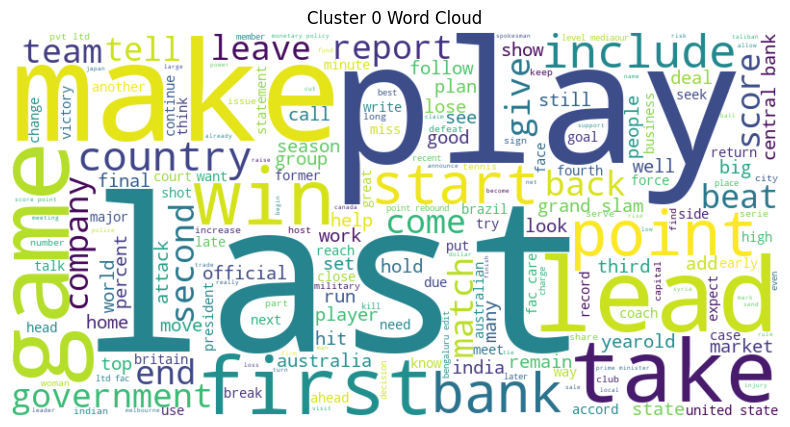

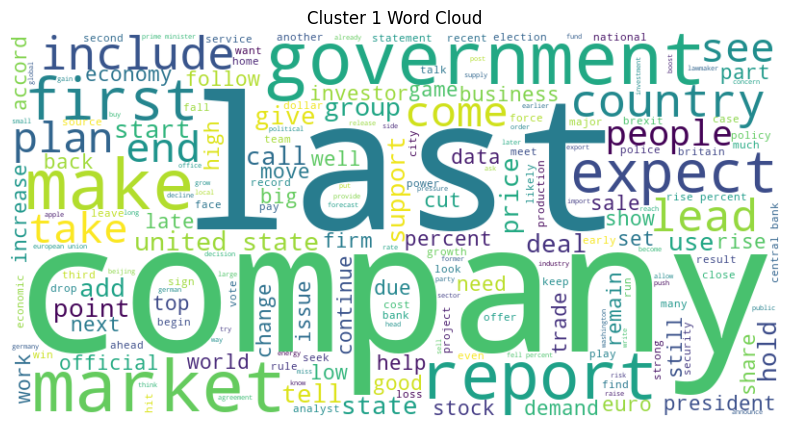

In [12]:
# 定义一个函数来生成词云
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# 获取每个聚类的高频词
for cluster in range(num_clusters):
    # 将属于同一聚类的文本合并为一个字符串
    cluster_text = ' '.join(test_data[test_data['cluster_label'] == cluster]['content'])
    plot_word_cloud(cluster_text, f'Cluster {cluster} Word Cloud')

In [13]:
# 评估聚类效果
if len(set(labels)) > 1:
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    print(f"轮廓系数: {silhouette}")
    print(f"Calinski - Harabasz 指数: {ch_score}")
else:
    print("由于簇的数量不大于 1，无法计算聚类评估指标。")


轮廓系数: 0.14662156999111176
Calinski - Harabasz 指数: 465.6182482059154


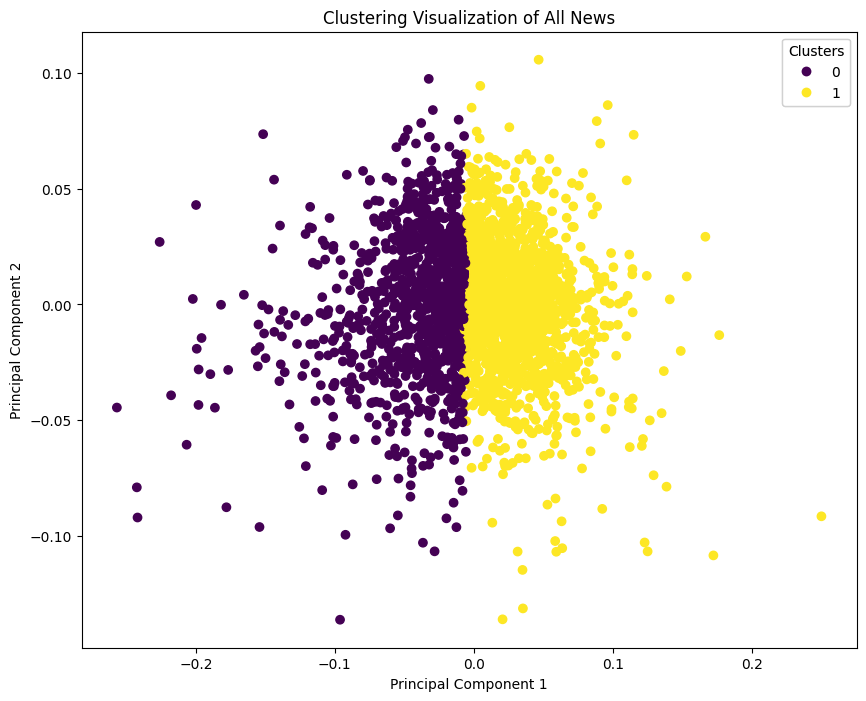

In [14]:
# 使用 PCA 将数据降到二维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 绘制散点图
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)
plt.title('Clustering Visualization of All News')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [8]:


# 将日期转换为日期类型
test_data['date'] = pd.to_datetime(test_data['date'])
# 按日期分组
grouped = test_data.groupby('date')

# 加载 DistilBERT 模型和分词器
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# 存储每天每个聚类的情感指数结果
sentiment_results = []

# 将模型移到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []
        
        for content in cluster_data['content']:
            # 如果 content 是列表，将其转换为字符串
            if isinstance(content, list):
                text = " ".join(str(item) for item in content)
            else:
                text = str(content)
                
            try:
                # 编码文本，设置最大长度为 512
                inputs = tokenizer(text, return_tensors="pt", truncation=True, 
                                 padding=True, max_length=512)
                # 将输入移到相同的设备
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # 获取模型输出
                with torch.no_grad():
                    outputs = model(**inputs)
                
                # 处理预测结果
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1)
                
                # DistilBERT SST-2 的标签顺序：negative [0], positive [1]
                positive_prob = probabilities[0][1].item()
                negative_prob = probabilities[0][0].item()
                
                # 计算情感得分：积极概率 - 消极概率
                sentiment_score = positive_prob - negative_prob
                sentiment_scores.append(sentiment_score)
                
            except Exception as e:
                print(f"处理文本时出错: {text[:50]}...，错误信息: {e}")
                continue
        
        # 计算平均情感得分
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        sentiment_results.append({
            'date': date,
            'cluster': cluster,
            'sentiment_score': average_sentiment,
            'num_samples': len(sentiment_scores)  # 添加样本数，便于检查
        })

# 创建 DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

# 打印结果
print(sentiment_df)

         date  cluster  sentiment_score  num_samples
0  2018-12-31        0        -0.705525            3
1  2018-12-31        1        -0.963242            5
2  2019-01-01        0        -0.594715           58
3  2019-01-01        1        -0.853337           54
4  2019-01-02        0        -0.774129          113
..        ...      ...              ...          ...
59 2019-01-29        1        -0.877580           47
60 2019-01-30        0        -0.689017           37
61 2019-01-30        1        -0.886970           49
62 2019-01-31        0        -0.701687           29
63 2019-01-31        1        -0.930287           37

[64 rows x 4 columns]


In [15]:
# change the sentiment method and use VADER
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 将日期转换为日期类型
test_data['date'] = pd.to_datetime(test_data['date'])
# 按日期分组
grouped = test_data.groupby('date')

# 初始化VADER
analyzer = SentimentIntensityAnalyzer()

# 存储每天每个聚类的情感指数结果
sentiment_results = []

for date, group in grouped:
    for cluster in range(num_clusters):
        cluster_data = group[group['cluster_label'] == cluster]
        sentiment_scores = []
        
        for content in cluster_data['content']:
            # 如果 content 是列表，将其转换为字符串
            if isinstance(content, list):
                text = " ".join(str(item) for item in content)
            else:
                text = str(content)
            
            try:
                # 使用VADER计算情绪得分
                sentiment = analyzer.polarity_scores(text)
                compound_score = sentiment['compound']  # 综合得分作为情绪得分
                sentiment_scores.append(compound_score)
            except Exception as e:
                print(f"处理文本时出错: {text[:50]}...，错误信息: {e}")
                continue
        
        # 计算平均情感得分
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        
        sentiment_results.append({
            'date': date,
            'cluster': cluster,
            'sentiment_score': average_sentiment,
            'num_samples': len(sentiment_scores)  # 添加样本数，便于检查
        })

# 创建 DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

# 打印结果
print(sentiment_df)

         date  cluster  sentiment_score  num_samples
0  2018-12-31        0        -0.337133            3
1  2018-12-31        1         0.221140            5
2  2019-01-01        0         0.424224           58
3  2019-01-01        1         0.084007           54
4  2019-01-02        0         0.076802           99
..        ...      ...              ...          ...
59 2019-01-29        1         0.021260           48
60 2019-01-30        0         0.133761           36
61 2019-01-30        1         0.154122           50
62 2019-01-31        0         0.358876           25
63 2019-01-31        1         0.431844           41

[64 rows x 4 columns]
